In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import LSTM, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences


data = pd.read_csv('RIGHT_.csv')


In [ ]:
# Visualizar la distribución de las sesiones
sns.countplot(x='label', data=data)
plt.title('Distribución de Sesiones')
plt.show()

In [111]:
# División de datos (puedes ajustar según tu necesidad)
train_sessions, test_sessions = train_test_split(data['label'].unique(), test_size=0.2, random_state=42)
train_data = data[data['label'].isin(train_sessions)]
test_data = data[data['label'].isin(test_sessions)]

In [ ]:
# print(len(train_data))
# print(len(test_data))
# print(train_data)
# print(test_data)
print(len(train_data[train_data['label'] == 25]))

In [112]:
# Normalización
scaler = StandardScaler()

# Copia explícita para evitar la advertencia
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

# Aplicar la transformación a las copias
train_data_copy[['horizontal', 'vertical']] = scaler.fit_transform(train_data_copy[['horizontal', 'vertical']])
test_data_copy[['horizontal', 'vertical']] = scaler.transform(test_data_copy[['horizontal', 'vertical']])


In [ ]:
# Find the maximum sequence length in the training data
max_length_train = max(len(group[['horizontal', 'vertical']]) for _, group in train_data.groupby('label'))

# Find the maximum sequence length in the testing data
max_length_test = max(len(group[['horizontal', 'vertical']]) for _, group in test_data.groupby('label'))

# Set timesteps to the maximum of these two lengths
timesteps = max(max_length_train, max_length_test)

# Now, use this timesteps value to create your sequences
X_train = []
y_train = []
for label, group in train_data.groupby('label'):
    seq = group[['horizontal', 'vertical']].values
    # Pad sequences that are shorter than timestepsa
    if len(seq) < timesteps:
        seq = np.pad(seq, ((0, timesteps - len(seq)), (0, 0)), 'constant')
    X_train.append(seq[:timesteps])
    y_train.append(1 if 'R' in group['movement_type'].values else 0)

X_test = []
y_test = []
for label, group in test_data.groupby('label'):
    seq = group[['horizontal', 'vertical']].values
    # Pad sequences that are shorter than timesteps
    if len(seq) < timesteps:
        seq = np.pad(seq, ((0, timesteps - len(seq)), (0, 0)), 'constant')
    X_test.append(seq[:timesteps])
    y_test.append(1 if 'R' in group['movement_type'].values else 0)

# Convert X_train, y_train, X_test, and y_test to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Now, the number of sequences in X_train and X_test should match the number of labels in y_train and y_test
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [113]:
X_train = []
y_train = []
for label, group in train_data.groupby('label'):
    seq = group[['horizontal', 'vertical']].values
    X_train.append(seq)
    y_train.append(1 if 'R' in group['movement_type'].values else 0)

X_test = []
y_test = []
for label, group in test_data.groupby('label'):
    seq = group[['horizontal', 'vertical']].values
    X_test.append(seq)
    y_test.append(1 if 'R' in group['movement_type'].values else 0)

# Convert X_train, y_train, X_test, and y_test to numpy arrays
X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=object)
y_test = np.array(y_test)

In [ ]:
print(timesteps)

In [ ]:
# Define your model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(timesteps, 2)))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Check if X_train or y_train is empty
if len(X_train) == 0 or len(y_train) == 0:
    print("X_train or y_train is empty. Please check your data and timesteps.")
else:
    # Train your model
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Evaluate your model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [114]:
# Define your model
model = Sequential()
model.add(LSTM(50, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Pad the sequences to a fixed length
X_train_padded = pad_sequences(X_train, dtype='float32', padding='post')
X_test_padded = pad_sequences(X_test, dtype='float32', padding='post')

# Now, you can feed the padded sequences into your model
model.fit(X_train_padded, y_train, epochs=10, batch_size=32)

# Evaluate your model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
2/2 [==============================] - 13s 2s/step - loss: 0.7081 - accuracy: 0.1795
Epoch 2/10
2/2 [==============================] - 4s 2s/step - loss: 0.6424 - accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 5s 2s/step - loss: 0.5845 - accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 5s 2s/step - loss: 0.5338 - accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 5s 2s/step - loss: 0.4864 - accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 5s 2s/step - loss: 0.4400 - accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 5s 2s/step - loss: 0.3935 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 5s 2s/step - loss: 0.3464 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 5s 2s/step - loss: 0.2987 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 3s 3s/step - loss: 0.2167 - accuracy: 1.0000
Test Accuracy: 100.00%


In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predictions to binary labels
y_pred = (y_pred > 0.5).astype(int)

# Calculate the accuracy of the predictions
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# You can also print a confusion matrix to see how well the model is predicting each class
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

In [115]:
# Save the model
model.save('my_model.h5')

c:\Users\Asus\Documents\aUniversidad\SEMESTRE 23-2\Bio_I\Proyecto\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pandas as pd
from keras.models import load_model

# Load the probe signal
probe_data = pd.read_csv('prueba.csv')

# Preprocess the probe signal
probe_signal = probe_data[['horizontal', 'vertical']].values[:timesteps]

# Pad the signal with zeros if it's too short
if len(probe_signal) < timesteps:
    probe_signal = np.pad(probe_signal, ((0, timesteps - len(probe_signal)), (0, 0)), 'constant')

# Make sure the signal is the correct shape
if probe_signal.shape != (timesteps, 2):
    print("The signal is not the correct shape.")
else:
    # Reshape the signal to match the model's input shape
    probe_signal = probe_signal.reshape(1, timesteps, 2)

    # Use the model to predict the label of the probe signal
    prediction = model.predict(probe_signal)

    # Convert the prediction to a binary label
    prediction = (prediction > 0.5).astype(int)

    print(f"The predicted label is: {prediction}")



# Load the model
loaded_model = load_model('my_model.h5')

In [ ]:
import matplotlib.pyplot as plt

# Assume probe_signal is your preprocessed probe signal
# Use the model to predict the label of the probe signal
prediction = model.predict(probe_signal)

# Convert the prediction to a binary label
prediction_label = (prediction > 0.5).astype(int)

# Plot the probe signal
plt.figure(figsize=(10, 6))
plt.plot(probe_signal[0])

# Add the prediction to the title of the plot
plt.title(f'Probe Signal (Predicted Label: {prediction_label[0][0]})')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the probe signal
probe_data = pd.read_csv('prueba.csv')

# Plot the 'horizontal' and 'vertical' columns
plt.figure(figsize=(10, 6))
plt.plot(probe_data['horizontal'], label='Horizontal')
plt.plot(probe_data['vertical'], label='Vertical')
plt.title('Probe Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Load your dataset
data = pd.read_csv('SuperData.csv')

# Get the unique session labels
sessions = data['label'].unique()

# Plot each session
for session in sessions:
    session_data = data[data['label'] == session]
    
    plt.figure(figsize=(10, 6))
    plt.plot(session_data['horizontal'], label='Horizontal')
    plt.plot(session_data['vertical'], label='Vertical')
    plt.title(f'Session {session}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

c:\Users\Asus\Documents\aUniversidad\SEMESTRE 23-2\Bio_I\Proyecto\venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 2s 2s/step
Predictions: [[0.7502419]]


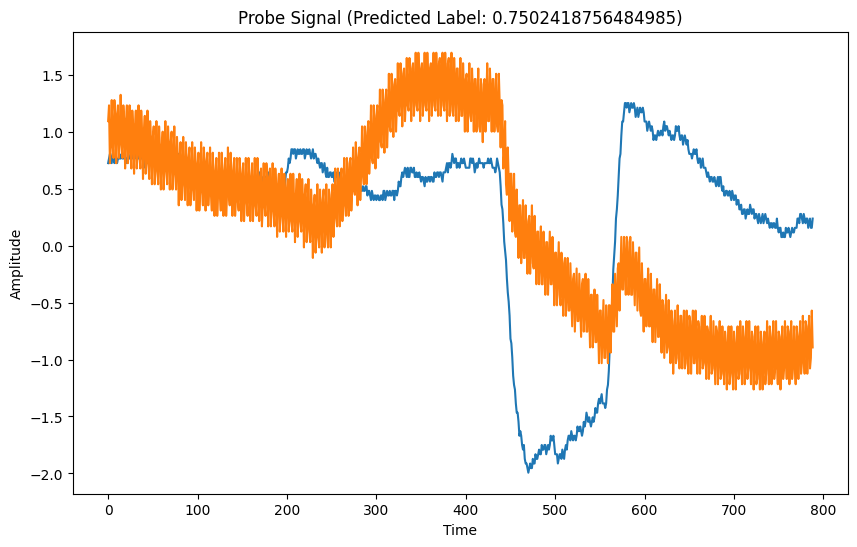

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the test dataset
test_data = pd.read_csv('prueba.csv')
loaded_model = load_model('my_model.h5')

# Preprocess the test data in the same way as your training data
X_test_new = []
for label, group in test_data.groupby('label'):
    seq = group[['horizontal', 'vertical']].values
    seq = scaler.transform(seq)  # Normalize the data
    X_test_new.append(seq)
X_test_new = pad_sequences(X_test_new, dtype='float32', padding='post')

# Use the model to make predictions
y_pred = loaded_model.predict(X_test_new)

# Print out the predictions and the test data
print("Predictions:", y_pred)
plt.figure(figsize=(10, 6))
plt.plot(X_test_new[0])

# Add the prediction to the title of the plot
plt.title(f'Probe Signal (Predicted Label: {y_pred[0][0]})')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
